
# Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

## 1. Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy

#vis
import pyLDAvis
import pyLDAvis.gensim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS




In [ ]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 30
page_size = 100

reviews = []
seats = []
tra_type=[]


# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    for row in parsed_content.find_all("tr"):
        seat_type_element = row.find("td", {"class": "review-rating-header cabin_flown"})
        if seat_type_element:
            seat_type = seat_type_element.find_next("td", {"class": "review-value"}).get_text()
            seats.append(seat_type)
            type_of_traveller = row.find_next("td",{"class":"review-rating-header type_of_traveller"})
            if type_of_traveller:
                guest_type = type_of_traveller.find_next("td",{"class":"review-value"}).get_text()
                tra_type.append(guest_type)
            else:
                tra_type.append("Null")





In [ ]:
# Pour data into my created DataFrame
df = pd.DataFrame()
df["ID"]= np.arange(1,len(reviews)+1)
df["reviews"] = reviews
df["Traveller_type"]=tra_type
df["Seat_type"]=seats


## 2. Data Preprocessing:

In [ ]:
# Cleaning the data
df[["prefix","Reviews"]]=df[df["reviews"].str.contains("|")].reviews.str.split("|",expand=True)
df.drop('prefix', axis="columns",inplace=True)
df.loc[df["Reviews"].isna(),"Reviews"]=df.reviews
df["Reviews"]=df.Reviews.str.strip()
df.drop("reviews",axis=1,inplace=True)
df=df[df.Traveller_type !="Null"]



In [ ]:
# DataFrame after cleaning.
df

,ID,Traveller_type,Seat_type,Reviews
0,1,Couple Leisure,Economy Class,On a recent flight from Cyprus BA621 on 23/11/...
1,2,Business,Economy Class,Flight BA 0560 arrived in Rome on 11 December ...
2,3,Solo Leisure,Business Class,This was the first time I flew British Airways...
3,4,Solo Leisure,Business Class,Pretty good flight but still some small things...
4,5,Solo Leisure,First Class,"Check in was fine, but no priority/fast track ..."
...,...,...,...,...
2994,2995,Couple Leisure,Business Class,Excellent Club Europe service. I am amazed how...
2995,2996,Business,Business Class,Boarding delayed in MIA due to weather but BA ...
2996,2997,Couple Leisure,Economy Class,Our return flight from Barbados to England was...
2997,2998,Couple Leisure,Economy Class,Flight was picked because it got us from Riyad...


## 3. Sentimental Analysis using Roberta Pretrained Model

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch


In [ ]:
Model=f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(Model)
model=AutoModelForSequenceClassification.from_pretrained(Model)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
def roberta_sentiment_analysis(review):
    encoded_text=tokenizer(review, return_tensors='pt', truncation=True, max_length=512)
    output=model(**encoded_text)
    scores=output[0][0].detach().numpy()
    scores=softmax(scores)
    scores_dict= {
        "negative": scores[0],
        "neutral": scores[1],
        "positive": scores[2]
    }
    return scores_dict

In [ ]:
res={}

for index, row in df.iterrows():
   try:
    review= row["Reviews"]
    myid=row["ID"]
    res[myid]=roberta_sentiment_analysis(review)
   except RuntimeError:
        print(f"Error at {myid}")

In [ ]:
#Create a new df called roberta merging with DataFrame df on matching column "ID"
roberta=pd.DataFrame(res).T
roberta=roberta.reset_index().rename(columns={"index":"ID"})
roberta=roberta.merge(df,on="ID", how="left")
roberta["sentiment"] = roberta[["negative", "positive", "neutral"]].idxmax(axis=1)


In [ ]:
roberta

,ID,negative,neutral,positive,Traveller_type,Seat_type,Reviews,sentiment
0,1,0.919980,0.072850,0.007170,Couple Leisure,Economy Class,On a recent flight from Cyprus BA621 on 23/11/...,negative
1,2,0.789149,0.184303,0.026548,Business,Economy Class,Flight BA 0560 arrived in Rome on 11 December ...,negative
2,3,0.894509,0.092927,0.012564,Solo Leisure,Business Class,This was the first time I flew British Airways...,negative
3,4,0.033442,0.167989,0.798569,Solo Leisure,Business Class,Pretty good flight but still some small things...,positive
4,5,0.241237,0.340123,0.418640,Solo Leisure,First Class,"Check in was fine, but no priority/fast track ...",positive
...,...,...,...,...,...,...,...,...
2965,2995,0.002302,0.018237,0.979461,Couple Leisure,Business Class,Excellent Club Europe service. I am amazed how...,positive
2966,2996,0.015029,0.134832,0.850139,Business,Business Class,Boarding delayed in MIA due to weather but BA ...,positive
2967,2997,0.852640,0.129316,0.018043,Couple Leisure,Economy Class,Our return flight from Barbados to England was...,negative
2968,2998,0.271876,0.481246,0.246878,Couple Leisure,Economy Class,Flight was picked because it got us from Riyad...,neutral


## 4. WORDCLOUDING


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Tokenization, Lemmatization, Stopwords deletion
stopwords=stopwords.words("english")
tok_sen=[]
def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    nlp=spacy.load("en_core_web_sm",disable=['parser','ner'])
    doc=nlp(text)
    new_text=[]
    for token in doc:
      if token.pos_ in allowed_postags and token.lower_ not in stopwords:
        new_text.append(token.lemma_)
    tok_sen.append(new_text)
    final=" ".join(new_text)
    return final

AttributeError: 'list' object has no attribute 'words'

In [ ]:
# Processed each review and pour into new column #processed_review using list.
results=[]
for index, row in roberta.iterrows():
    sentence=row["Reviews"]
    result=lemmatization(sentence)
    results.append(result)
roberta["processed_review"]=results



In [ ]:
roberta["token_processed_review"]=tok_sen

In [ ]:
roberta

,ID,negative,neutral,positive,Traveller_type,Seat_type,Reviews,sentiment,processed_review,token_processed_review
0,1,0.919980,0.072850,0.007170,Couple Leisure,Economy Class,On a recent flight from Cyprus BA621 on 23/11/...,negative,recent flight 23/11/24 second cabin door close...,"[recent, flight, 23/11/24, second, cabin, door..."
1,2,0.789149,0.184303,0.026548,Business,Economy Class,Flight BA 0560 arrived in Rome on 11 December ...,negative,flight arrive passenger receive sms say luggag...,"[flight, arrive, passenger, receive, sms, say,..."
2,3,0.894509,0.092927,0.012564,Solo Leisure,Business Class,This was the first time I flew British Airways...,negative,first time fly huge disappointment seat quite ...,"[first, time, fly, huge, disappointment, seat,..."
3,4,0.033442,0.167989,0.798569,Solo Leisure,Business Class,Pretty good flight but still some small things...,positive,pretty good flight still small thing improve c...,"[pretty, good, flight, still, small, thing, im..."
4,5,0.241237,0.340123,0.418640,Solo Leisure,First Class,"Check in was fine, but no priority/fast track ...",positive,check fine priority fast track line security b...,"[check, fine, priority, fast, track, line, sec..."
...,...,...,...,...,...,...,...,...,...,...
2965,2995,0.002302,0.018237,0.979461,Couple Leisure,Business Class,Excellent Club Europe service. I am amazed how...,positive,service amazed european carrier serve much bus...,"[service, amazed, european, carrier, serve, mu..."
2966,2996,0.015029,0.134832,0.850139,Business,Business Class,Boarding delayed in MIA due to weather but BA ...,positive,boarding delay weather keep passenger update b...,"[boarding, delay, weather, keep, passenger, up..."
2967,2997,0.852640,0.129316,0.018043,Couple Leisure,Economy Class,Our return flight from Barbados to England was...,negative,return flight barbado delay hour experience ai...,"[return, flight, barbado, delay, hour, experie..."
2968,2998,0.271876,0.481246,0.246878,Couple Leisure,Economy Class,Flight was picked because it got us from Riyad...,neutral,flight pick get reasonable amount time fail in...,"[flight, pick, get, reasonable, amount, time, ..."


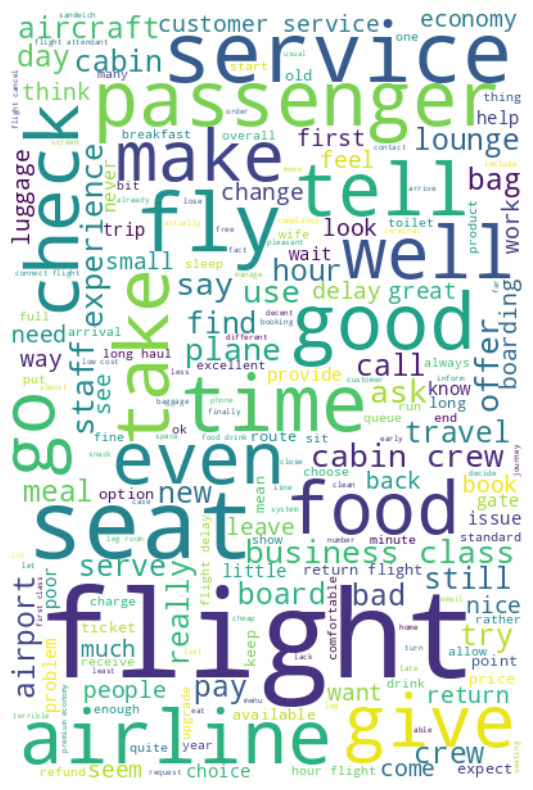

In [ ]:
#Create and visualize the Wordcloud
wc=WordCloud(background_color="white",height=600,width=400)
wc.generate(" ".join(roberta["processed_review"]))
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## 5. Topic Modelling: LDA (Latent Dirichlet Allocation)

In [ ]:
#Bigrams and Trigrams:
bigram_phrases=gensim.models.Phrases(tok_sen,min_count=5,threshold=100)
trigram_phrases=gensim.models.Phrases(bigram_phrases[tok_sen],min_count=5,threshold=100)
bigram=gensim.models.phrases.Phraser(bigram_phrases)
trigram=gensim.models.phrases.Phraser(trigram_phrases)
def make_bigrams(text):
  return bigram[text]
def make_trigrams(text):
  return trigram[text]

roberta["bi_trigram"]=roberta.token_processed_review.apply(lambda x: make_bigrams(x)).apply(lambda x: make_trigrams(x))


In [ ]:
roberta

,ID,negative,neutral,positive,Traveller_type,Seat_type,Reviews,sentiment,processed_review,token_processed_review,bi_trigram
0,1,0.919980,0.072850,0.007170,Couple Leisure,Economy Class,On a recent flight from Cyprus BA621 on 23/11/...,negative,recent flight 23/11/24 second cabin door close...,"[recent, flight, 23/11/24, second, cabin, door...","[recent, flight, 23/11/24, second, cabin, door..."
1,2,0.789149,0.184303,0.026548,Business,Economy Class,Flight BA 0560 arrived in Rome on 11 December ...,negative,flight arrive passenger receive sms say luggag...,"[flight, arrive, passenger, receive, sms, say,...","[flight, arrive, passenger, receive, sms, say,..."
2,3,0.894509,0.092927,0.012564,Solo Leisure,Business Class,This was the first time I flew British Airways...,negative,first time fly huge disappointment seat quite ...,"[first, time, fly, huge, disappointment, seat,...","[first, time, fly, huge, disappointment, seat,..."
3,4,0.033442,0.167989,0.798569,Solo Leisure,Business Class,Pretty good flight but still some small things...,positive,pretty good flight still small thing improve c...,"[pretty, good, flight, still, small, thing, im...","[pretty, good, flight, still, small, thing, im..."
4,5,0.241237,0.340123,0.418640,Solo Leisure,First Class,"Check in was fine, but no priority/fast track ...",positive,check fine priority fast track line security b...,"[check, fine, priority, fast, track, line, sec...","[check, fine, priority, fast_track, line, secu..."
...,...,...,...,...,...,...,...,...,...,...,...
2965,2995,0.002302,0.018237,0.979461,Couple Leisure,Business Class,Excellent Club Europe service. I am amazed how...,positive,service amazed european carrier serve much bus...,"[service, amazed, european, carrier, serve, mu...","[service, amazed, european, carrier, serve, mu..."
2966,2996,0.015029,0.134832,0.850139,Business,Business Class,Boarding delayed in MIA due to weather but BA ...,positive,boarding delay weather keep passenger update b...,"[boarding, delay, weather, keep, passenger, up...","[boarding, delay, weather, keep, passenger, up..."
2967,2997,0.852640,0.129316,0.018043,Couple Leisure,Economy Class,Our return flight from Barbados to England was...,negative,return flight barbado delay hour experience ai...,"[return, flight, barbado, delay, hour, experie...","[return, flight, barbado, delay, hour, experie..."
2968,2998,0.271876,0.481246,0.246878,Couple Leisure,Economy Class,Flight was picked because it got us from Riyad...,neutral,flight pick get reasonable amount time fail in...,"[flight, pick, get, reasonable, amount, time, ...","[flight, pick, get, reasonable, amount, time, ..."


In [ ]:
roberta.drop("token_processed_review",axis=1,inplace=True)


In [ ]:
#TF-IDF REMOVAL:
from gensim.models import TfidfModel
import itertools
flat_list=list(itertools.chain(tok_sen))
id2word=corpora.Dictionary(flat_list)
corpus=[id2word.doc2bow(text) for text in flat_list]
tfidf=TfidfModel(corpus,id2word=id2word)
low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow



In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=4,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [ ]:
test_doc = corpus[-1]

vector = lda_model[test_doc]
print (vector)

def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    sub_li.reverse()
    return (sub_li)
new_vector = Sort(vector)
print (new_vector)

[(0, 0.68302923), (1, 0.11021411), (2, 0.11443574), (3, 0.09232098)]
[(0, 0.68302923), (2, 0.11443574), (1, 0.11021411), (3, 0.09232098)]


In [ ]:
import os

# Create the directory if it doesn't exist
os.makedirs('/content/models', exist_ok=True)

lda_model.save("/content/models/test_model.model")


In [ ]:


new_model = gensim.models.ldamodel.LdaModel.load("/content/models/test_model.model")


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)


In [ ]:
pyLDAvis.display(vis)

In [ ]:
roberta['topics'] = roberta['bi_trigram'].apply(lambda x: lda_model.get_document_topics(id2word.doc2bow(x)))

In [ ]:
roberta['dominant_topic'] = roberta['topics'].apply(lambda x: max(x, key=lambda item: item[1])[0])


In [ ]:
roberta

,ID,negative,neutral,positive,Traveller_type,Seat_type,Reviews,sentiment,processed_review,bi_trigram,topics,dominant_topic
0,1,0.919980,0.072850,0.007170,Couple Leisure,Economy Class,On a recent flight from Cyprus BA621 on 23/11/...,negative,recent flight 23/11/24 second cabin door close...,"[recent, flight, 23/11/24, second, cabin, door...","[(0, 0.2581776), (1, 0.019321386), (2, 0.72086...",2
1,2,0.789149,0.184303,0.026548,Business,Economy Class,Flight BA 0560 arrived in Rome on 11 December ...,negative,flight arrive passenger receive sms say luggag...,"[flight, arrive, passenger, receive, sms, say,...","[(0, 0.12098673), (2, 0.73423856), (3, 0.13780...",2
2,3,0.894509,0.092927,0.012564,Solo Leisure,Business Class,This was the first time I flew British Airways...,negative,first time fly huge disappointment seat quite ...,"[first, time, fly, huge, disappointment, seat,...","[(0, 0.1699852), (2, 0.6685293), (3, 0.15582554)]",2
3,4,0.033442,0.167989,0.798569,Solo Leisure,Business Class,Pretty good flight but still some small things...,positive,pretty good flight still small thing improve c...,"[pretty, good, flight, still, small, thing, im...","[(0, 0.46436158), (1, 0.40011373), (2, 0.13428...",0
4,5,0.241237,0.340123,0.418640,Solo Leisure,First Class,"Check in was fine, but no priority/fast track ...",positive,check fine priority fast track line security b...,"[check, fine, priority, fast_track, line, secu...","[(0, 0.4775477), (1, 0.41158384), (2, 0.108782...",0
...,...,...,...,...,...,...,...,...,...,...,...,...
2965,2995,0.002302,0.018237,0.979461,Couple Leisure,Business Class,Excellent Club Europe service. I am amazed how...,positive,service amazed european carrier serve much bus...,"[service, amazed, european, carrier, serve, mu...","[(0, 0.7921271), (1, 0.09416431), (2, 0.108732...",0
2966,2996,0.015029,0.134832,0.850139,Business,Business Class,Boarding delayed in MIA due to weather but BA ...,positive,boarding delay weather keep passenger update b...,"[boarding, delay, weather, keep, passenger, up...","[(0, 0.7703776), (1, 0.09070938), (2, 0.135278...",0
2967,2997,0.852640,0.129316,0.018043,Couple Leisure,Economy Class,Our return flight from Barbados to England was...,negative,return flight barbado delay hour experience ai...,"[return, flight, barbado, delay, hour, experie...","[(0, 0.20691565), (1, 0.10119195), (2, 0.60498...",2
2968,2998,0.271876,0.481246,0.246878,Couple Leisure,Economy Class,Flight was picked because it got us from Riyad...,neutral,flight pick get reasonable amount time fail in...,"[flight, pick, get, reasonable, amount, time, ...","[(0, 0.20439413), (1, 0.12178941), (2, 0.61679...",2


In [7]:
#Give name for each topic:
map={
    0:"In-Flight Service",
    1:"Flight Operations and Punctuality",
    2: "Onboard Dining and Amenities",
    3: "Customer Service and Support"
}
roberta["topic_name"]=roberta.dominant_topic.map(map)
df2=roberta


In [8]:
#drop unecessary columns
roberta.drop(["bi_trigram","topics","Reviews"],axis=1,inplace=True)

## 6. Analysis:
### *Main Questions*: **How is the customer feedback on their service experience with British Airways based on their textual review?**

In [63]:
roberta["topic_name"].value_counts()


,count
topic_name,
In-Flight Service,1966
Onboard Dining and Amenities,935
Flight Operations and Punctuality,43
Customer Service and Support,26


In [64]:
roberta.dominant_topic.value_counts()

,count
dominant_topic,
0,1966
2,935
1,43
3,26


### 6.1. In general, what is customers' attitude towards our British Airways Service ?

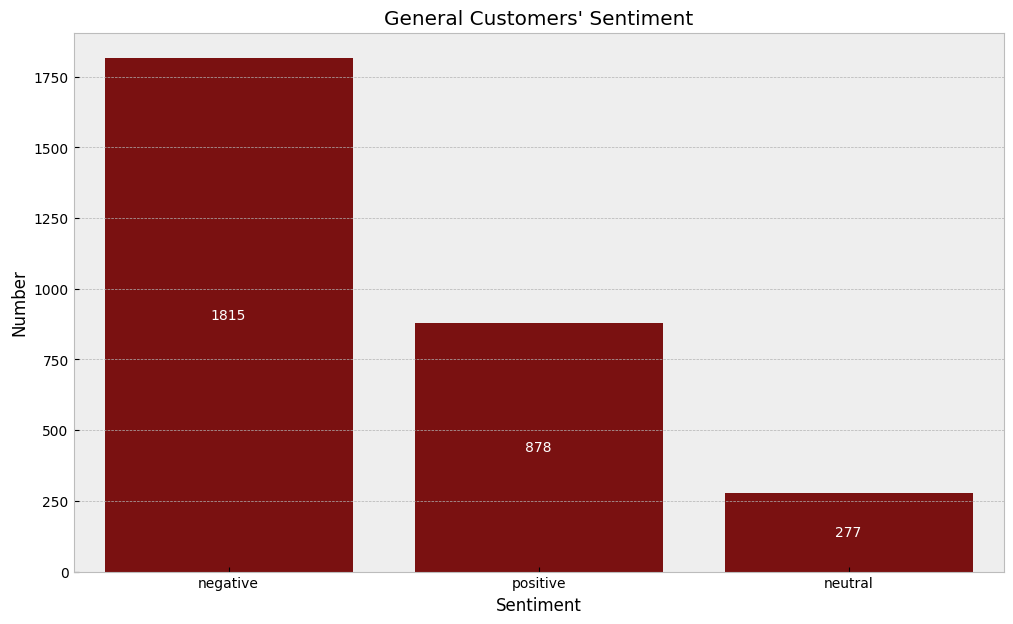

In [12]:
plt.style.use("bmh")
fig,ax=plt.subplots(figsize=(12,7))
sns.countplot(x=roberta.sentiment,color="#8B0000",ax=ax)
ax.set_xlabel("Sentiment")
ax.set_ylabel("Number")
ax.set_title("General Customers' Sentiment")
for container in ax.containers:
    ax.bar_label(container, label_type='center',color="white")
plt.show()


[<BarContainer object of 3 artists>]

### 6.2. What are main topics that have been discussed ?

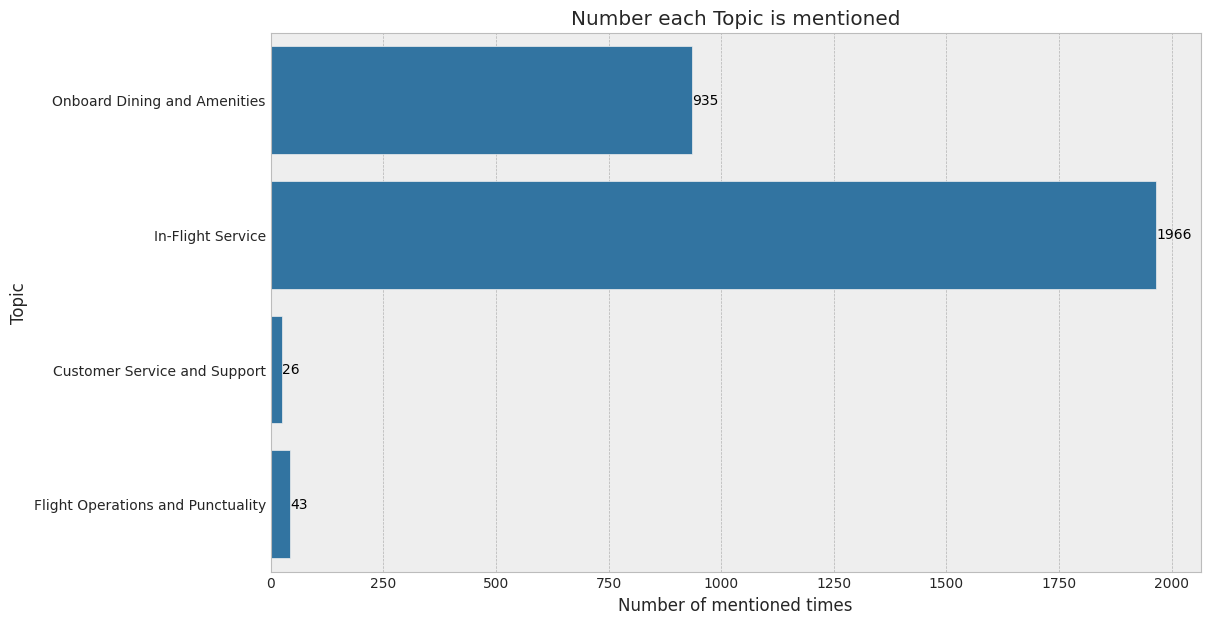

In [160]:
fig2,ax2=plt.subplots(figsize=(12,7))
sns.countplot(roberta.topic_name,color="#1f77b4",ax=ax2)
ax2.set_xlabel("Number of mentioned times")
ax2.set_ylabel("Topic")
ax2.set_title("Number each Topic is mentioned")
for container in ax2.containers:
  ax2.bar_label(container, label_type="edge",color="black")


### 6.3. how is the review attitude of each topic ?

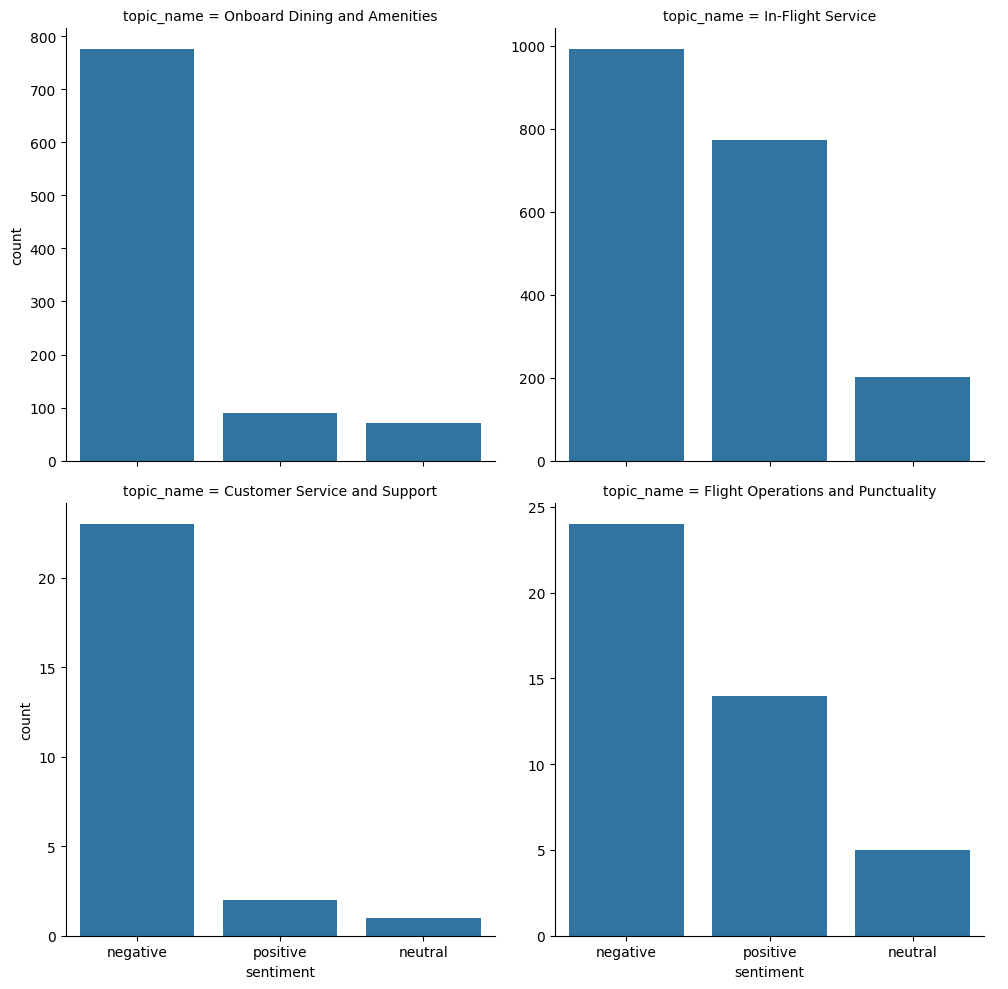

In [11]:
sns.catplot(data=roberta, x="sentiment",kind="count",col=roberta.topic_name,col_wrap=2,color="#1f77b4",sharey=False)
plt.show()

### 6.4. What is the relation between traveller type and their review ?

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
roberta

,ID,negative,neutral,positive,Traveller_type,Seat_type,Reviews,sentiment,processed_review,bi_trigram,topics,dominant_topic
0,1,0.919980,0.072850,0.007170,Couple Leisure,Economy Class,On a recent flight from Cyprus BA621 on 23/11/...,negative,recent flight 23/11/24 second cabin door close...,"['recent', 'flight', '23/11/24', 'second', 'ca...","[(0, 0.2581776), (1, 0.019321386), (2, 0.72086...",2
1,2,0.789149,0.184303,0.026548,Business,Economy Class,Flight BA 0560 arrived in Rome on 11 December ...,negative,flight arrive passenger receive sms say luggag...,"['flight', 'arrive', 'passenger', 'receive', '...","[(0, 0.12098673), (2, 0.73423856), (3, 0.13780...",2
2,3,0.894509,0.092927,0.012564,Solo Leisure,Business Class,This was the first time I flew British Airways...,negative,first time fly huge disappointment seat quite ...,"['first', 'time', 'fly', 'huge', 'disappointme...","[(0, 0.1699852), (2, 0.6685293), (3, 0.15582554)]",2
3,4,0.033442,0.167989,0.798569,Solo Leisure,Business Class,Pretty good flight but still some small things...,positive,pretty good flight still small thing improve c...,"['pretty', 'good', 'flight', 'still', 'small',...","[(0, 0.46436158), (1, 0.40011373), (2, 0.13428...",0
4,5,0.241237,0.340123,0.418641,Solo Leisure,First Class,"Check in was fine, but no priority/fast track ...",positive,check fine priority fast track line security b...,"['check', 'fine', 'priority', 'fast_track', 'l...","[(0, 0.4775477), (1, 0.41158384), (2, 0.108782...",0
...,...,...,...,...,...,...,...,...,...,...,...,...
2965,2995,0.002302,0.018237,0.979461,Couple Leisure,Business Class,Excellent Club Europe service. I am amazed how...,positive,service amazed european carrier serve much bus...,"['service', 'amazed', 'european', 'carrier', '...","[(0, 0.7921271), (1, 0.09416431), (2, 0.108732...",0
2966,2996,0.015029,0.134832,0.850139,Business,Business Class,Boarding delayed in MIA due to weather but BA ...,positive,boarding delay weather keep passenger update b...,"['boarding', 'delay', 'weather', 'keep', 'pass...","[(0, 0.7703776), (1, 0.09070938), (2, 0.135278...",0
2967,2997,0.852640,0.129316,0.018043,Couple Leisure,Economy Class,Our return flight from Barbados to England was...,negative,return flight barbado delay hour experience ai...,"['return', 'flight', 'barbado', 'delay', 'hour...","[(0, 0.20691565), (1, 0.10119195), (2, 0.60498...",2
2968,2998,0.271876,0.481246,0.246878,Couple Leisure,Economy Class,Flight was picked because it got us from Riyad...,neutral,flight pick get reasonable amount time fail in...,"['flight', 'pick', 'get', 'reasonable', 'amoun...","[(0, 0.20439413), (1, 0.12178941), (2, 0.61679...",2


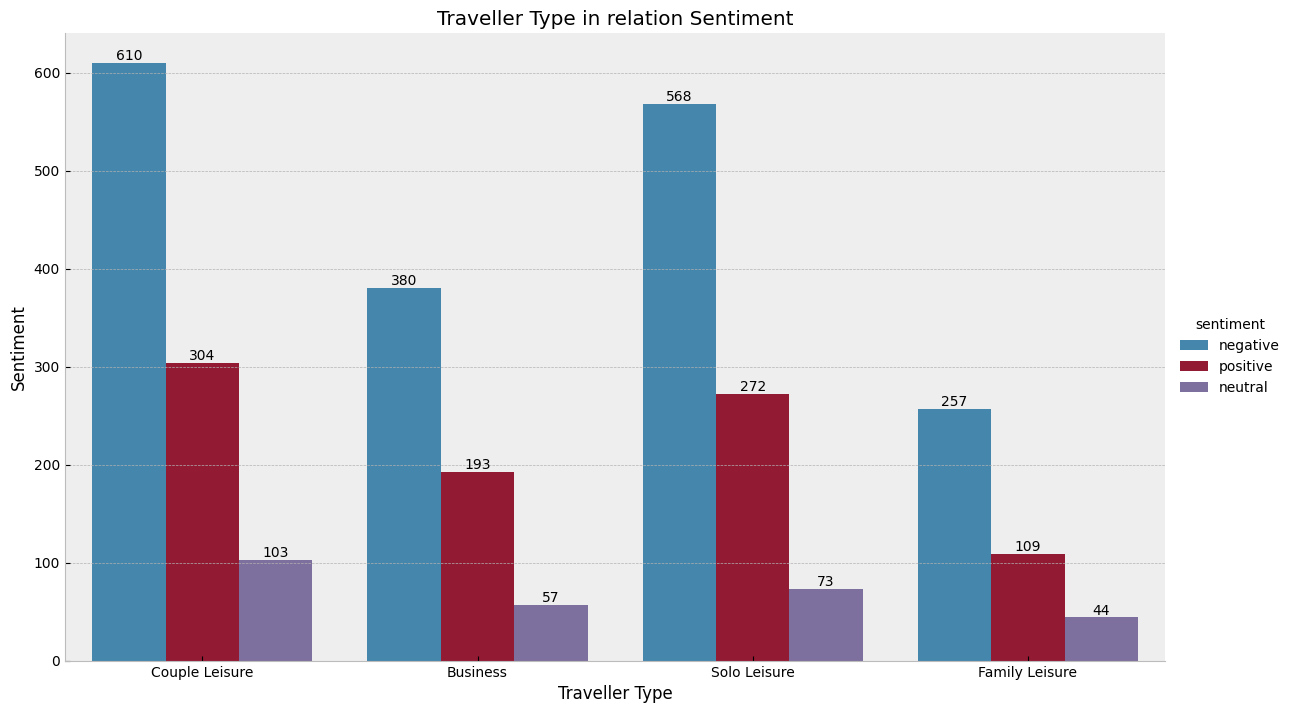

In [13]:
t=sns.catplot(data=roberta,x="Traveller_type", kind="count",hue="sentiment",height=7, aspect=1.7)
plt.xlabel("Traveller Type")
plt.ylabel("Sentiment")
plt.title("Traveller Type in relation Sentiment")
for ax in t.axes.flat:
  for container in ax.containers:
    ax.bar_label(container,label="center",color="black")


### 6.5. Do certain traveler types focus on specific topics more than others?



<class 'seaborn.axisgrid.FacetGrid'>


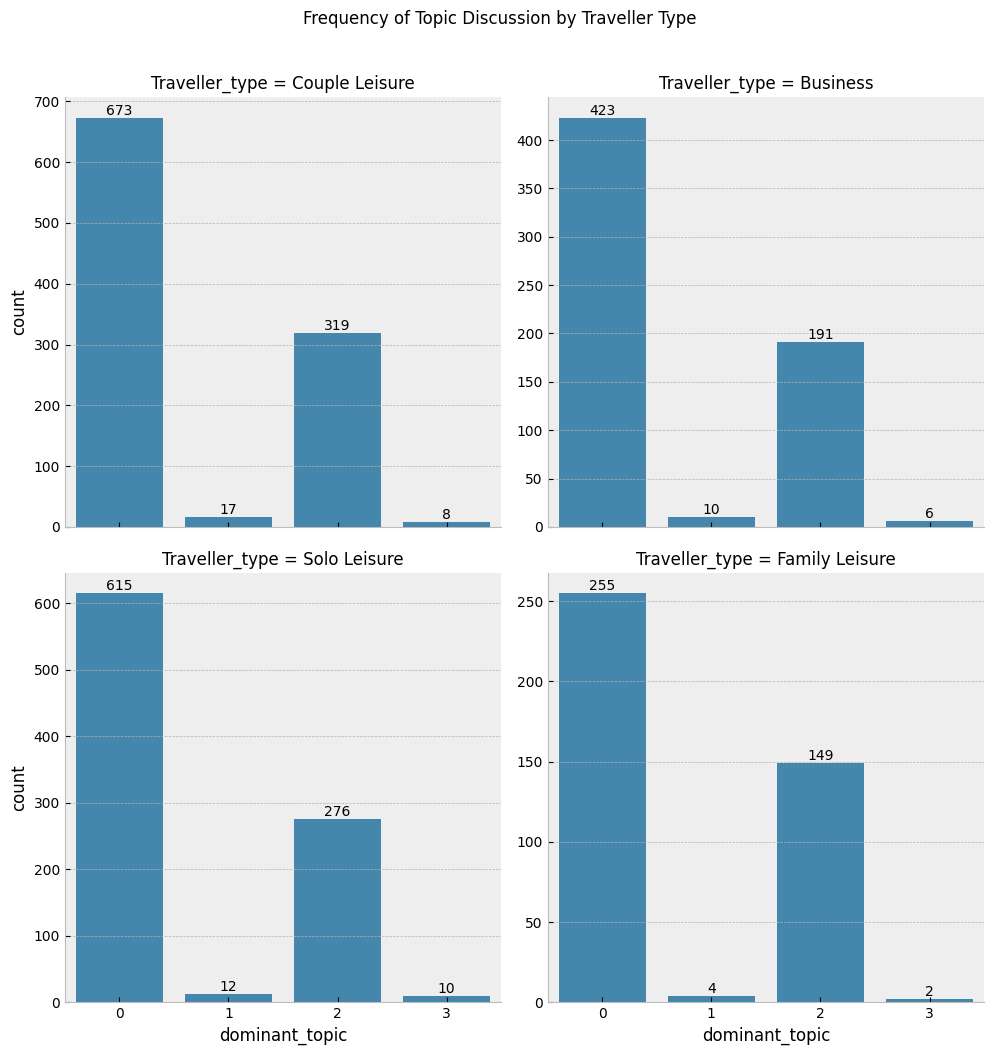

In [19]:
g=sns.catplot(data=roberta,x="dominant_topic",kind="count",col="Traveller_type",sharey=False, col_wrap=2)
print(type(g))
for ax in g.axes.flat:
  for container in ax.containers:
    ax.bar_label(container,label="edge",color="black")
g.fig.suptitle("Frequency of Topic Discussion by Traveller Type",y=1.05)
plt.show()

<class 'seaborn.axisgrid.FacetGrid'>


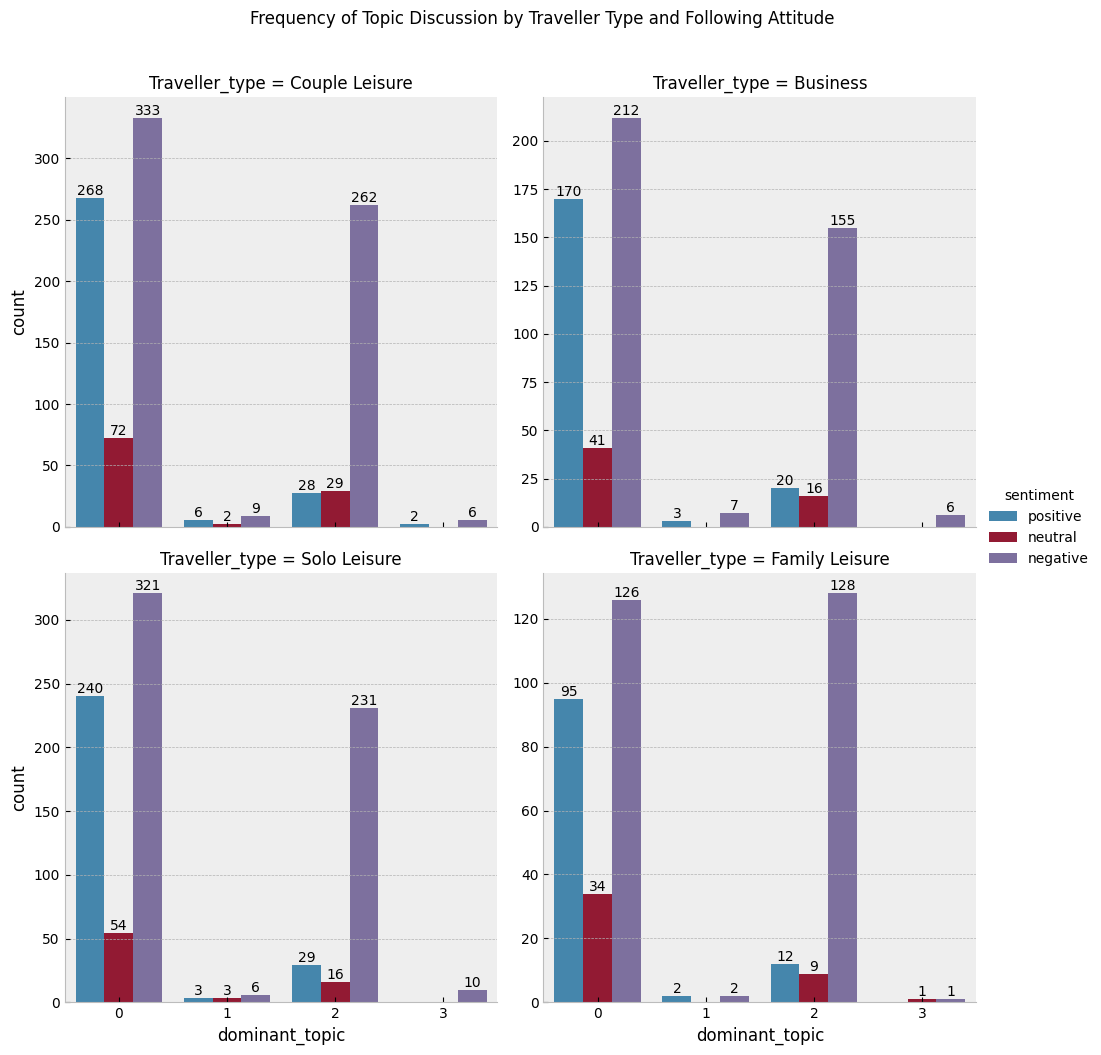

In [22]:
a=sns.catplot(data=roberta,x="dominant_topic",kind="count",col="Traveller_type",hue="sentiment",sharey=False, col_wrap=2)
print(type(g))
for ax in g.axes.flat:
  for container in ax.containers:
    ax.bar_label(container,label="edge",color="black")
a.fig.suptitle("Frequency of Topic Discussion by Traveller Type and Following Attitude",y=1.05)
for ax in a.axes.flat:
  for container in ax.containers:
    ax.bar_label(container,label_type="edge",color="black")
plt.show()

### 6.6. Proportion of customers giving reviews based on seat type:

In [147]:
seat_type=roberta.Seat_type.value_counts().reset_index()


Text(0.5, 1.0, 'Proportion of customers giving feedbacks')

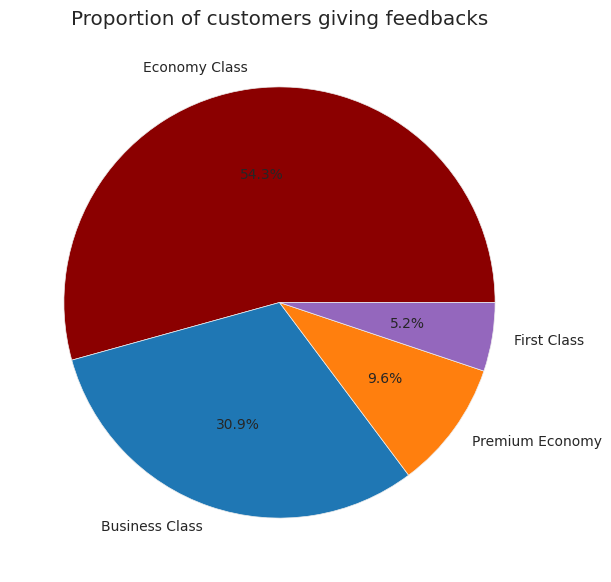

In [162]:
import matplotlib.colors as mcolors

colors = ["#8B0000","#1f77b4","#ff7f0e","#9467bd"]
lighter_colors = [mcolors.to_rgba(color, alpha=1) for color in colors]


fig3,ax3=plt.subplots(figsize=(14,7))
ax3.pie(seat_type["count"], labels=seat_type.Seat_type,autopct="%1.1f%%",colors=lighter_colors)
ax3.set_title("Proportion of customers giving feedbacks")


### 6.7.What customers in each seat type discuss the most ?

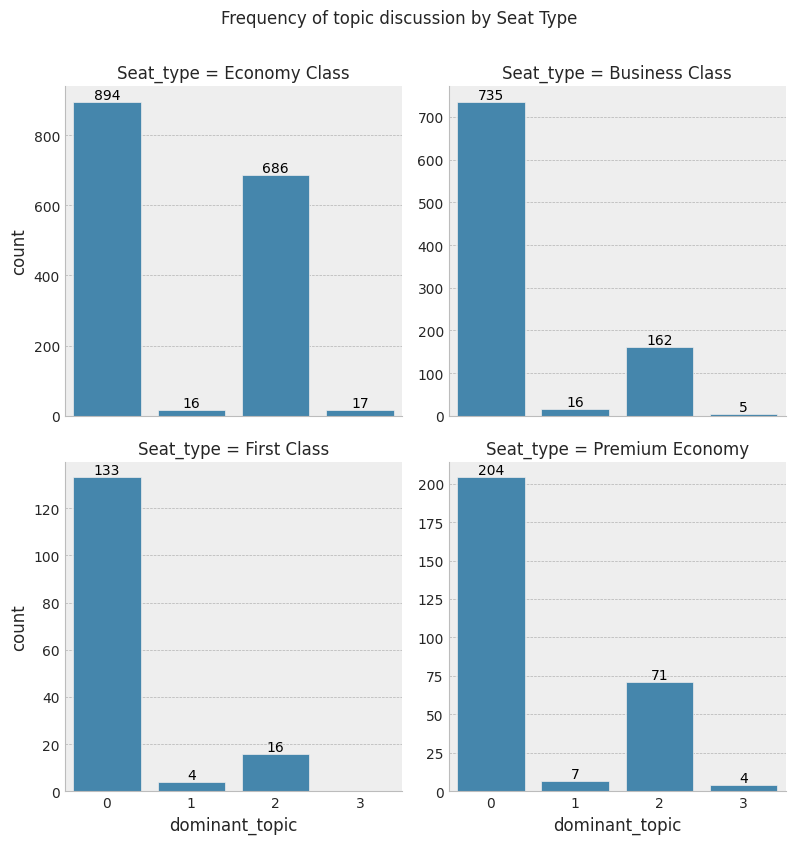

In [202]:
j=sns.catplot(data=roberta,x="dominant_topic",kind="count",col="Seat_type",sharey=False,col_wrap=2,height=4)
j.fig.suptitle("Frequency of topic discussion by Seat Type",y=1.05)
for ax in j.axes.flat:
  for container in ax.containers:
    ax.bar_label(container,label_type="edge",color="black")
plt.show()

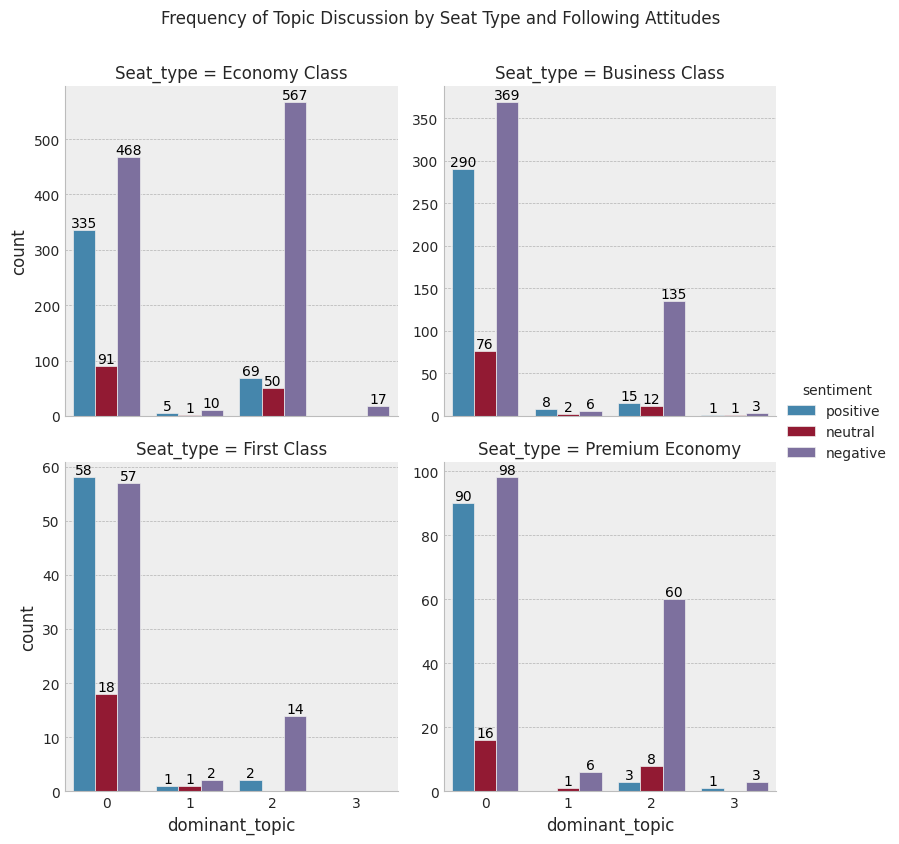

In [200]:
h=sns.catplot(data=roberta,x="dominant_topic",kind="count",col="Seat_type",hue="sentiment",sharey=False,col_wrap=2,height=4)
h.fig.suptitle("Frequency of Topic Discussion by Seat Type and Following Attitudes",y=1.05)
for ax in h.axes.flat:
  for container in ax.containers:
    ax.bar_label(container,label_type="edge",color="black")

plt.show()


In [ ]:
sns.catplot(data=roberta,x=,kind="count",col="Seat_type",sharey=False,col_wrap=2,height=4)
plt.show(

In [168]:
roberta

,ID,negative,neutral,positive,Traveller_type,Seat_type,sentiment,processed_review,dominant_topic,topic_name
0,1,0.919980,0.072850,0.007170,Couple Leisure,Economy Class,negative,recent flight 23/11/24 second cabin door close...,2,Onboard Dining and Amenities
1,2,0.789149,0.184303,0.026548,Business,Economy Class,negative,flight arrive passenger receive sms say luggag...,2,Onboard Dining and Amenities
2,3,0.894509,0.092927,0.012564,Solo Leisure,Business Class,negative,first time fly huge disappointment seat quite ...,2,Onboard Dining and Amenities
3,4,0.033442,0.167989,0.798569,Solo Leisure,Business Class,positive,pretty good flight still small thing improve c...,0,In-Flight Service
4,5,0.241237,0.340123,0.418641,Solo Leisure,First Class,positive,check fine priority fast track line security b...,0,In-Flight Service
...,...,...,...,...,...,...,...,...,...,...
2965,2995,0.002302,0.018237,0.979461,Couple Leisure,Business Class,positive,service amazed european carrier serve much bus...,0,In-Flight Service
2966,2996,0.015029,0.134832,0.850139,Business,Business Class,positive,boarding delay weather keep passenger update b...,0,In-Flight Service
2967,2997,0.852640,0.129316,0.018043,Couple Leisure,Economy Class,negative,return flight barbado delay hour experience ai...,2,Onboard Dining and Amenities
2968,2998,0.271876,0.481246,0.246878,Couple Leisure,Economy Class,neutral,flight pick get reasonable amount time fail in...,2,Onboard Dining and Amenities
